In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import argparse
import json

np.random.seed(42)

In [8]:
path = os.path.expanduser('~/MyMACS2/data/ATAC/RG_aligns/data_GSE')
name = 'GSM7790861'
#rg = 'RG:Z:AAACCCTGAGTTCTCC'
threshold = 0.4  
N = 100           
x_min = 64470145   
y_max = 64472144   
chrs = ['chr1']

In [31]:
db_top100_cells = pd.read_csv(f'{path}/{name}_top_100_rg_coordinates_of_reads.csv')
db_top100_cells.columns = ['RN', 'chr', 'x', 'y', 'RG', 'strand1', 'strand2']
db_top100_cells = db_top100_cells[['RG', 'chr', 'x', 'y']]
db_top100_cells.head()

,RG,chr,x,y
0,RG:Z:GGCTTCTACCGGTACC,chr1,9997,10392
1,RG:Z:GGCTTCTACCGGTACC,chr1,9997,10215
2,RG:Z:CGCTTAAGAAGAGGCT,chr1,9997,10411
3,RG:Z:AGGCGATGAAGAGGCT,chr1,10004,10083
4,RG:Z:AACCAACACGAGCCTC,chr1,10004,10083


In [33]:
with open(f'profile/{name}_RGs.txt', 'r') as file:
    RGs = [line.strip() for line in file]

In [36]:
blurred_data = {}

# Основной цикл
for rg in tqdm(RGs):
    blurred_data[rg] = {}
    
    rg_data = db_top100_cells[db_top100_cells['RG'] == rg]
    
    for chromosome in chrs:
        chr_data = rg_data[rg_data['chr'] == chromosome]
        
        chr_data_filtered = chr_data[(chr_data['y'] >= x_min) & (chr_data['x'] <= y_max)]

        blurred_data_samples = []
        for i in range(N):        
            sampled_data = chr_data_filtered.sample(frac=threshold, random_state=i)
            blurred_data_samples.append(sampled_data)
        
        blurred_data[rg][chromosome] = blurred_data_samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


In [56]:
blurred_data[RGs[15]]['chr1'][24].head()

,RG,chr,x,y
591227,RG:Z:CATTGTTACGAAATCA,chr1,64470832,64471019
591261,RG:Z:CATTGTTACGAAATCA,chr1,64471029,64471431


In [91]:
def count_intensity(data):
    
    max_y = max(data['y']) + 1
    start_end_count_in_chr = np.zeros((max_y, 2), dtype=int)

    # Фильтрация и расчёт длины
    #data['length'] = data['y'] - data['x']

    # Заполнение интенсивности
    for _, row in data[['x', 'y']].iterrows():
        x = row['x']
        y = row['y']
        start_end_count_in_chr[x, 0] += 1
        start_end_count_in_chr[y, 1] += 1

    intensity_nucleotides = np.cumsum(start_end_count_in_chr[:, 0] - np.pad(start_end_count_in_chr[:, 1][1:], (1, 0), 'constant'))

    return intensity_nucleotides.tolist()




In [92]:
intensity_data = count_intensity(chr_data_filtered)
intensity_data = intensity_data[x_min : y_max + 1]

In [98]:
blured_intensity = count_intensity(blurred_data_list[12])

blured_intensity = blured_intensity[x_min : y_max + 1]
blured_intensity += [0] * (2000 - len(blured_intensity))

In [99]:
len(blured_intensity)

2000

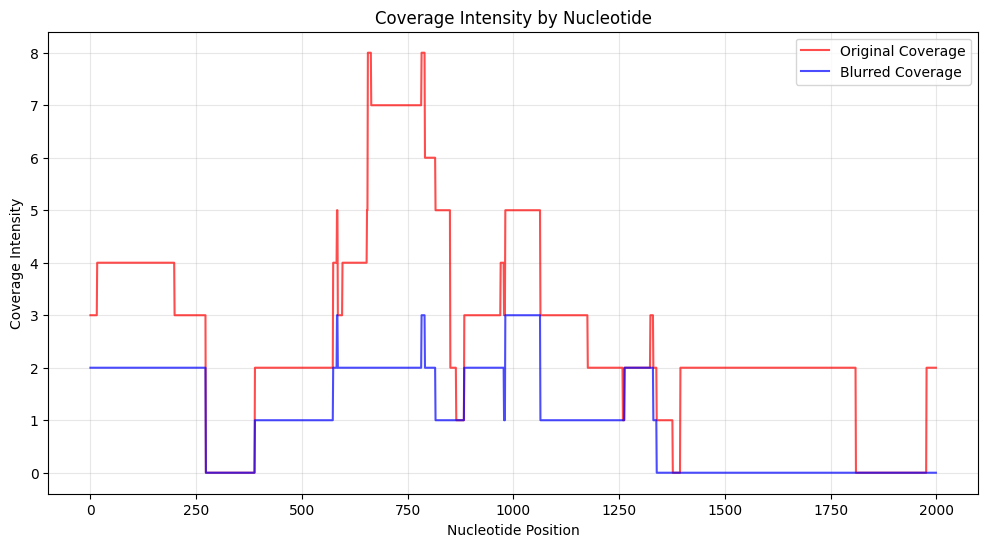

In [100]:
import matplotlib.pyplot as plt

def plot_intensity(original_intensity, blurred_intensity):
    """
    Функция для визуализации покрытий оригинальных и зашумленных данных.
    
    :param original_intensity: Интенсивность покрытия оригинальных данных.
    :param blurred_intensity: Интенсивность покрытия зашумленных данных.
    :param x_min: Начало отрезка (минимальный нуклеотид).
    :param x_max: Конец отрезка (максимальный нуклеотид).
    """
    positions = range(2000)

    plt.figure(figsize=(12, 6))

    # Оригинальное покрытие - красным
    plt.plot(positions, original_intensity, label="Original Coverage", color="red", alpha=0.7)

    # Зашумленное покрытие - синим
    plt.plot(positions, blurred_intensity, label="Blurred Coverage", color="blue", alpha=0.7)

    plt.title("Coverage Intensity by Nucleotide")
    plt.xlabel("Nucleotide Position")
    plt.ylabel("Coverage Intensity")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Параметры
x_min = 64470145
x_max = 64472144

# Визуализация покрытий
plot_intensity(intensity_data, blured_intensity)


In [27]:
sum(coverage_filtered)

np.int64(79072)